In [ ]:
import pandas as pd
from google.colab import drive

# Mount Google Drive to access the dataset
drive.mount('/content/drive')

# Path to the dataset
file_path = '/content/drive/My Drive/bank/bank-additional-full.csv'

# Load the dataset
data = pd.read_csv(file_path, sep=';')


# Display the first few rows and summary
df_info = data.info()
df_head = data.head()
df_nulls = data.isnull().sum()
df_description = data.describe(include='all')

df_head, df_info, df_nulls, df_description



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  objec

(   age        job  marital    education  default housing loan    contact  \
 0   56  housemaid  married     basic.4y       no      no   no  telephone   
 1   57   services  married  high.school  unknown      no   no  telephone   
 2   37   services  married  high.school       no     yes   no  telephone   
 3   40     admin.  married     basic.6y       no      no   no  telephone   
 4   56   services  married  high.school       no      no  yes  telephone   
 
   month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
 0   may         mon  ...         1    999         0  nonexistent          1.1   
 1   may         mon  ...         1    999         0  nonexistent          1.1   
 2   may         mon  ...         1    999         0  nonexistent          1.1   
 3   may         mon  ...         1    999         0  nonexistent          1.1   
 4   may         mon  ...         1    999         0  nonexistent          1.1   
 
    cons.price.idx  cons.conf.idx  euribor

Data Preprocessing

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Make a copy to avoid modifying original data
df_clean = data.copy()

# 1. Encode the target variable 'y'
df_clean['y'] = df_clean['y'].map({'yes': 1, 'no': 0})

# 2. Encode categorical variables using Label Encoding for simplicity
categorical_cols = ['job', 'marital', 'education', 'default', 'housing',
                    'loan', 'contact', 'month', 'day_of_week', 'poutcome']
label_encoder = LabelEncoder()

for col in categorical_cols:
    df_clean[col] = label_encoder.fit_transform(df_clean[col])

# 3. Replace the value 999 in the 'pdays' column with a more meaningful value, such as -1, to indicate "not contacted."
df_clean['pdays'] = df_clean['pdays'].replace(999, -1)

# 4. Scale numerical features
scaler = StandardScaler()
numerical_cols = ['age', 'duration', 'campaign', 'pdays', 'previous',
                  'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
                  'euribor3m', 'nr.employed']

df_clean[numerical_cols] = scaler.fit_transform(df_clean[numerical_cols])

# Verify cleaned data
df_clean.head(), df_clean.describe()


(        age  job  marital  education  default  housing  loan  contact  month  \
 0  1.533034    3        1          0        0        0     0        1      6   
 1  1.628993    7        1          3        1        0     0        1      6   
 2 -0.290186    7        1          3        0        2     0        1      6   
 3 -0.002309    0        1          1        0        0     0        1      6   
 4  1.533034    7        1          3        0        0     2        1      6   
 
    day_of_week  ...  campaign     pdays  previous  poutcome  emp.var.rate  \
 0            1  ... -0.565922 -0.170834 -0.349494         1      0.648092   
 1            1  ... -0.565922 -0.170834 -0.349494         1      0.648092   
 2            1  ... -0.565922 -0.170834 -0.349494         1      0.648092   
 3            1  ... -0.565922 -0.170834 -0.349494         1      0.648092   
 4            1  ... -0.565922 -0.170834 -0.349494         1      0.648092   
 
    cons.price.idx  cons.conf.idx  euribor

Model Implementation
1. Split the Data

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into features (X) and target (y)
X = df_clean.drop(columns=['y'])
y = df_clean['y']

# Train-Test Split: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Verify shapes of splits
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((32950, 20), (8238, 20), (32950,), (8238,))

2. Random Forest Classifier

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      7310
           1       0.69      0.54      0.60       928

    accuracy                           0.92      8238
   macro avg       0.82      0.75      0.78      8238
weighted avg       0.91      0.92      0.92      8238

Random Forest AUC-ROC Score: 0.9506


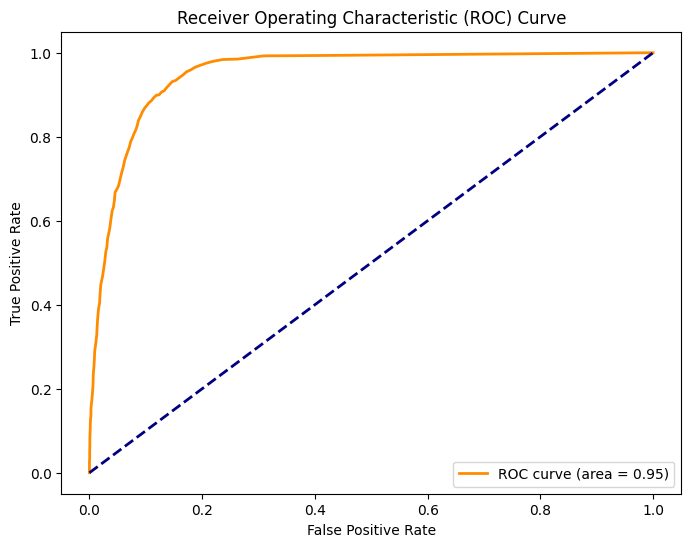

In [ ]:
# Initialize and train the Random Forest Classifier and plot the roc-auc

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve

# Initialize and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)
y_prob = rf_classifier.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Classification report
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate and display the AUC-ROC score
print(f"Random Forest AUC-ROC Score: {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()




3. Neural Network

MLP Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      7310
           1       0.62      0.55      0.58       928

    accuracy                           0.91      8238
   macro avg       0.78      0.75      0.77      8238
weighted avg       0.91      0.91      0.91      8238

MLP AUC-ROC Score: 0.9425


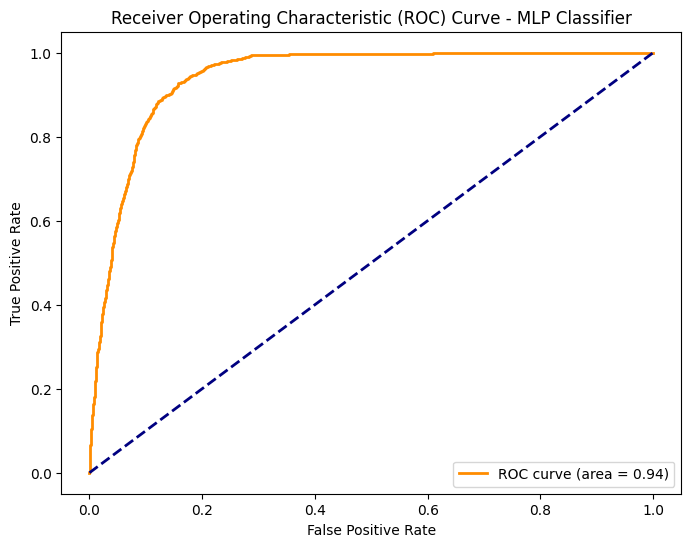

In [ ]:
# Initialize and train the Neural Network using MLPClassifier and plot the ROC curve

from sklearn.neural_network import MLPClassifier

# Initialize and train the MLPClassifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42) # Increased max_iter
mlp_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_mlp = mlp_classifier.predict(X_test)
y_prob_mlp = mlp_classifier.predict_proba(X_test)[:, 1]

# Plot the ROC curve for MLP Classifier
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, y_prob_mlp)
roc_auc_mlp = roc_auc_score(y_test, y_prob_mlp)

print("MLP Classification Report:")
print(classification_report(y_test, y_pred_mlp))

print(f"MLP AUC-ROC Score: {roc_auc_mlp:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr_mlp, tpr_mlp, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_mlp:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - MLP Classifier')
plt.legend(loc='lower right')
plt.show()

Compare Models

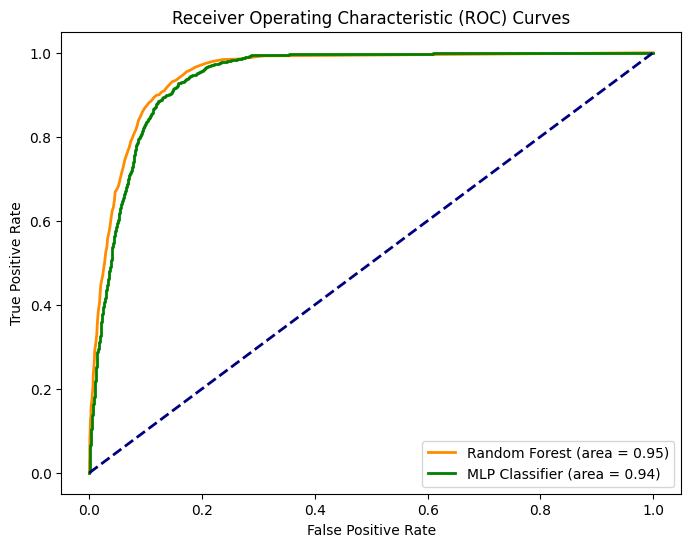

In [ ]:
# Plot ROC curves for both models

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Random Forest (area = {roc_auc:.2f})')
plt.plot(fpr_mlp, tpr_mlp, color='green', lw=2, label=f'MLP Classifier (area = {roc_auc_mlp:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

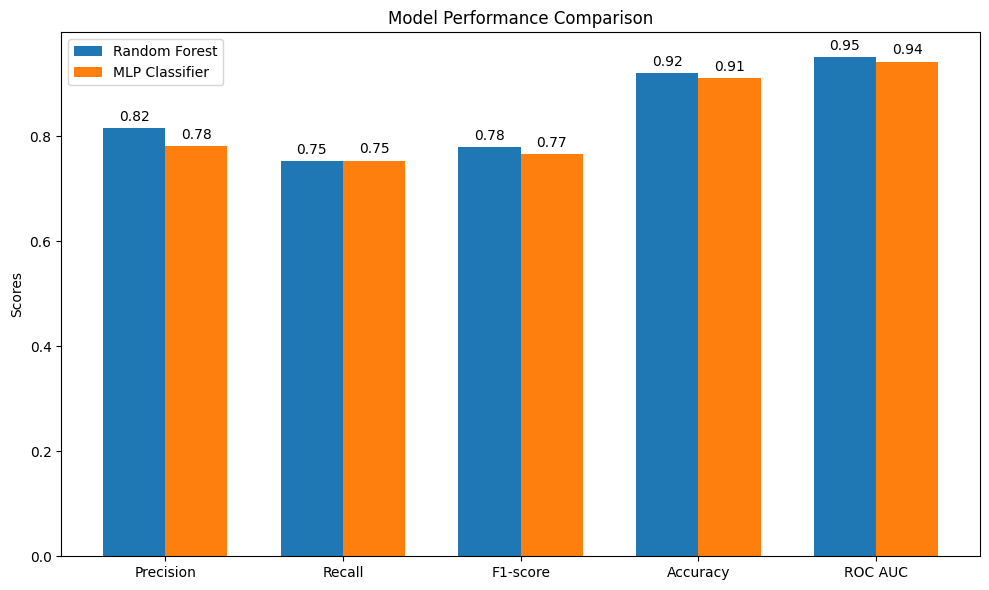

In [ ]:
# Visualize Precision, Recall, and F1-scores and accuracy for both models in same plot

import matplotlib.pyplot as plt
import numpy as np

def plot_metrics(y_true, y_pred_rf, y_pred_mlp, y_prob_rf, y_prob_mlp):

    # Random Forest Metrics
    rf_report = classification_report(y_true, y_pred_rf, output_dict=True)
    rf_precision = rf_report['macro avg']['precision']
    rf_recall = rf_report['macro avg']['recall']
    rf_f1 = rf_report['macro avg']['f1-score']
    rf_accuracy = rf_report['accuracy']
    rf_roc_auc = roc_auc_score(y_true, y_prob_rf)


    # MLP Metrics
    mlp_report = classification_report(y_true, y_pred_mlp, output_dict=True)
    mlp_precision = mlp_report['macro avg']['precision']
    mlp_recall = mlp_report['macro avg']['recall']
    mlp_f1 = mlp_report['macro avg']['f1-score']
    mlp_accuracy = mlp_report['accuracy']
    mlp_roc_auc = roc_auc_score(y_true, y_prob_mlp)

    metrics = ['Precision', 'Recall', 'F1-score', 'Accuracy', 'ROC AUC']
    rf_scores = [rf_precision, rf_recall, rf_f1, rf_accuracy, rf_roc_auc]
    mlp_scores = [mlp_precision, mlp_recall, mlp_f1, mlp_accuracy, mlp_roc_auc]


    x = np.arange(len(metrics))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, rf_scores, width, label='Random Forest')
    rects2 = ax.bar(x + width/2, mlp_scores, width, label='MLP Classifier')


    ax.set_ylabel('Scores')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()


    def autolabel(rects):
        for rect in rects:  # Add a text label above each bar in rects to show its height value.
            height = rect.get_height()
            ax.annotate('{:.2f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.show()


plot_metrics(y_test, y_pred, y_pred_mlp, y_prob, y_prob_mlp)

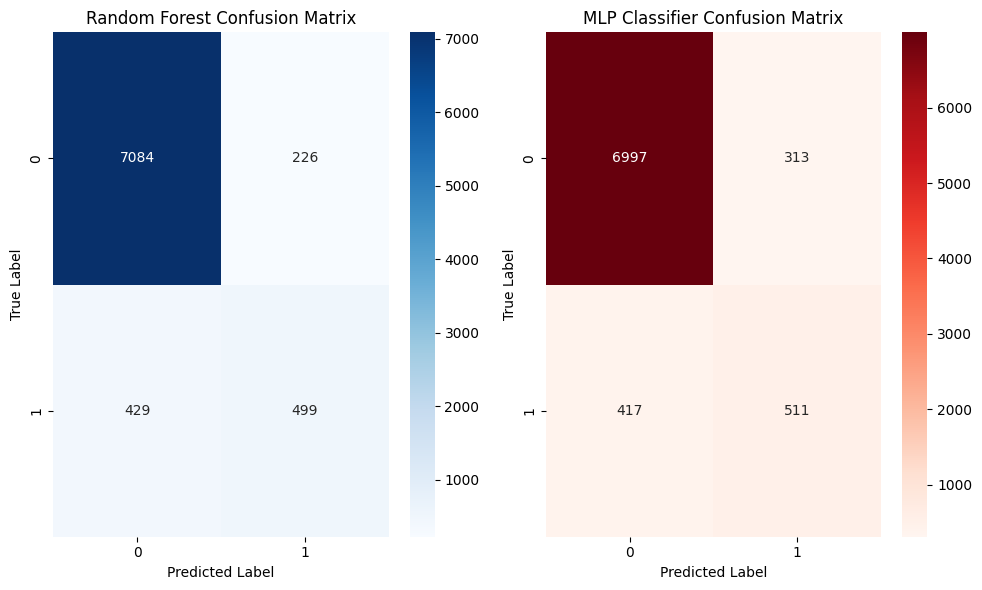

In [ ]:
# Visualize confusion matrices for both models

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrices(y_true, y_pred_rf, y_pred_mlp):

    fig, axes = plt.subplots(1, 2, figsize=(10, 6))

    # Confusion matrix for Random Forest
    cm_rf = confusion_matrix(y_true, y_pred_rf)
    sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", ax=axes[0])
    axes[0].set_title("Random Forest Confusion Matrix")
    axes[0].set_xlabel("Predicted Label")
    axes[0].set_ylabel("True Label")


    # Confusion matrix for MLP Classifier
    cm_mlp = confusion_matrix(y_true, y_pred_mlp)
    sns.heatmap(cm_mlp, annot=True, fmt="d", cmap="Reds", ax=axes[1])
    axes[1].set_title("MLP Classifier Confusion Matrix")
    axes[1].set_xlabel("Predicted Label")
    axes[1].set_ylabel("True Label")

    plt.tight_layout()
    plt.show()

plot_confusion_matrices(y_test, y_pred, y_pred_mlp)

Experiments
1. Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define Random Forest with GridSearchCV
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='roc_auc', verbose=1)
grid_rf.fit(X_train, y_train)

# Best parameters and performance
print("Best Parameters:", grid_rf.best_params_)
print("Best ROC-AUC:", grid_rf.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 150}
Best ROC-AUC: 0.9448728412988501


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# Initialize Random Forest with best parameters
rf_optimized = RandomForestClassifier(
    n_estimators=150,
    max_depth=20,
    min_samples_split=10,
    random_state=42
)

# Train the model
rf_optimized.fit(X_train, y_train)

# Predictions
y_pred_rf_opt = rf_optimized.predict(X_test)
y_pred_rf_opt_proba = rf_optimized.predict_proba(X_test)[:, 1]

# Evaluation metrics
accuracy_rf_opt = accuracy_score(y_test, y_pred_rf_opt)
roc_auc_rf_opt = roc_auc_score(y_test, y_pred_rf_opt_proba)
cm_rf_opt = confusion_matrix(y_test, y_pred_rf_opt)

# Results
print("Optimized Random Forest Accuracy:", accuracy_rf_opt)
print("Optimized Random Forest ROC-AUC:", roc_auc_rf_opt)
print("Confusion Matrix:\n", cm_rf_opt)


Optimized Random Forest Accuracy: 0.9209759650400583
Optimized Random Forest ROC-AUC: 0.9533988926364452
Confusion Matrix:
 [[7091  219]
 [ 432  496]]


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid_nn = {
    'hidden_layer_sizes': [(64, 32), (128, 64), (128, 64, 32)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [200]
}

# Initialize GridSearchCV
grid_search_nn = GridSearchCV(
    estimator=MLPClassifier(random_state=42),
    param_grid=param_grid_nn,
    cv=3,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

# Fit the model
grid_search_nn.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search_nn.best_params_)
print("Best ROC-AUC Score:", grid_search_nn.best_score_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (128, 64, 32), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'sgd'}
Best ROC-AUC Score: 0.9365060919120799


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# Initialize the optimized MLP classifier with the best hyperparameters
mlp_optimized = MLPClassifier(activation='relu', hidden_layer_sizes=(128, 64), learning_rate_init=0.001, max_iter=200, random_state=42, solver='adam')

# Train the optimized MLP classifier
mlp_optimized.fit(X_train, y_train)

# Make predictions using the optimized MLP classifier
y_pred_mlp_optimized = mlp_optimized.predict(X_test)
y_prob_mlp_optimized = mlp_optimized.predict_proba(X_test)[:, 1]

# Evaluate the optimized MLP classifier
accuracy_mlp_optimized = accuracy_score(y_test, y_pred_mlp_optimized)
roc_auc_mlp_optimized = roc_auc_score(y_test, y_prob_mlp_optimized)
cm_mlp_optimized = confusion_matrix(y_test, y_pred_mlp_optimized)

# Results
print("Optimized MLP Classifier Accuracy:", accuracy_mlp_optimized)
print("Optimized MLP Classifier ROC-AUC:", roc_auc_mlp_optimized)
print("Confusion Matrix:\n", cm_mlp_optimized)

Optimized MLP Classifier Accuracy: 0.9059237679048313
Optimized MLP Classifier ROC-AUC: 0.9211683039294305
Confusion Matrix:
 [[6988  322]
 [ 453  475]]


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
!pip install tensorflow
!pip install tensorflow matplotlib


Training and Validation loss over epochs

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8732 - loss: 0.3615 - val_accuracy: 0.8905 - val_loss: 0.2801
Epoch 2/20
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8914 - loss: 0.2754 - val_accuracy: 0.8946 - val_loss: 0.2544
Epoch 3/20
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8920 - loss: 0.2585 - val_accuracy: 0.8990 - val_loss: 0.2374
Epoch 4/20
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9004 - loss: 0.2340 - val_accuracy: 0.9025 - val_loss: 0.2260
Epoch 5/20
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9017 - loss: 0.2308 - val_accuracy: 0.9050 - val_loss: 0.2182
Epoch 6/20
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9030 - loss: 0.2227 - val_accuracy: 0.9056 - val_loss: 0.2129
Epoch 7/20
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9063 - loss: 0.2159 - val_accuracy: 0.9086 - val_loss: 0.2091
Epoch 8/20
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9071 - loss: 0.2157 - 

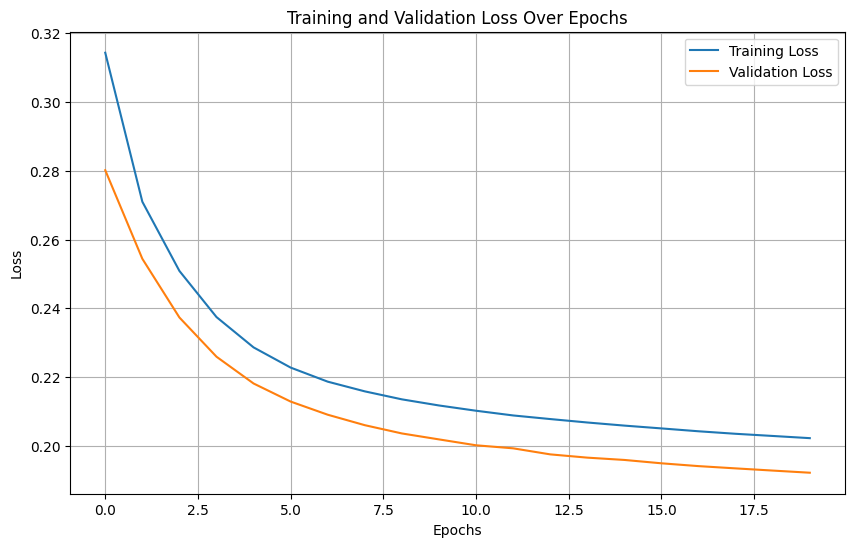

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

# Define the Neural Network model
keras_model = Sequential([
    Dense(128, activation='tanh', input_shape=(X_train.shape[1],)),
    Dense(64, activation='tanh'),
    Dense(32, activation='tanh'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
keras_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model and store the history
history = keras_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)

# Plot training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


2. Feature Importance and Subset Experiments

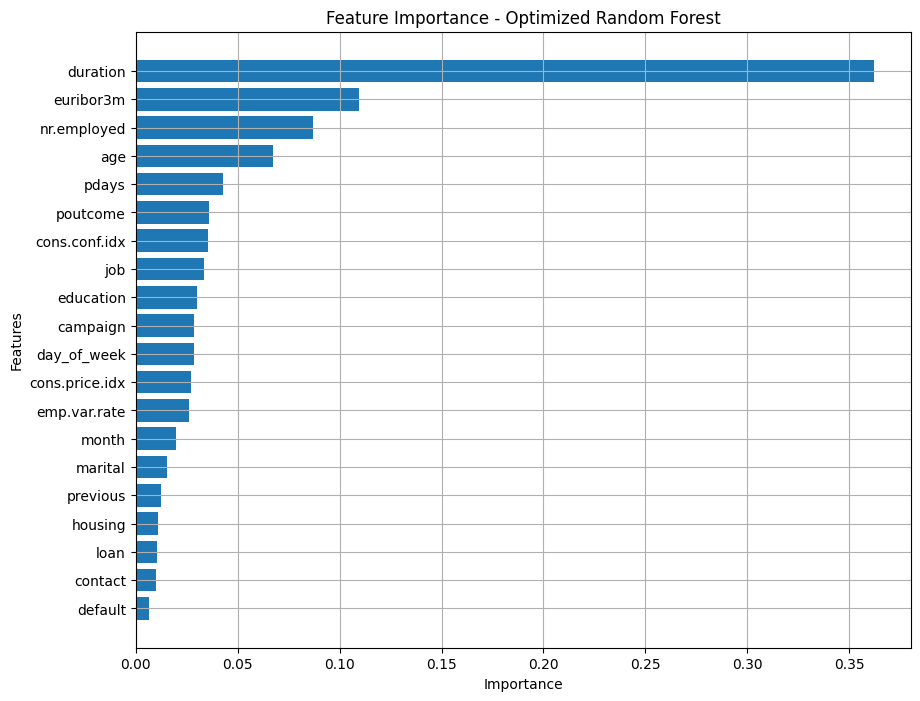

Subset Features: Index(['default', 'contact', 'loan', 'housing', 'previous'], dtype='object')
Subset Accuracy: 0.9208545763534839
Subset ROC-AUC: 0.9526976508325864


In [ ]:
# Feature Importance for Random Forest
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# Extract feature importances from the trained Random Forest
rf_importances = rf_optimized.feature_importances_
feature_names = X_train.columns

# Sort features by importance
sorted_indices_rf = rf_importances.argsort()

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(feature_names[sorted_indices_rf], rf_importances[sorted_indices_rf])
plt.title('Feature Importance - Optimized Random Forest')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.grid()
plt.show()

# Identify least important features
least_important_rf = feature_names[sorted_indices_rf][:5]

# Subset experiment: drop least important features
X_train_subset_rf = X_train.drop(columns=least_important_rf)
X_test_subset_rf = X_test.drop(columns=least_important_rf)

# Retrain Random Forest with subset features
rf_subset = RandomForestClassifier(
    n_estimators=150,
    max_depth=20,
    min_samples_split=10,
    random_state=42
)
rf_subset.fit(X_train_subset_rf, y_train)

# Evaluate performance with subset features
y_pred_rf_subset = rf_subset.predict(X_test_subset_rf)
y_pred_rf_subset_proba = rf_subset.predict_proba(X_test_subset_rf)[:, 1]

accuracy_rf_subset = accuracy_score(y_test, y_pred_rf_subset)
roc_auc_rf_subset = roc_auc_score(y_test, y_pred_rf_subset_proba)

print("Subset Features:", least_important_rf)
print("Subset Accuracy:", accuracy_rf_subset)
print("Subset ROC-AUC:", roc_auc_rf_subset)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


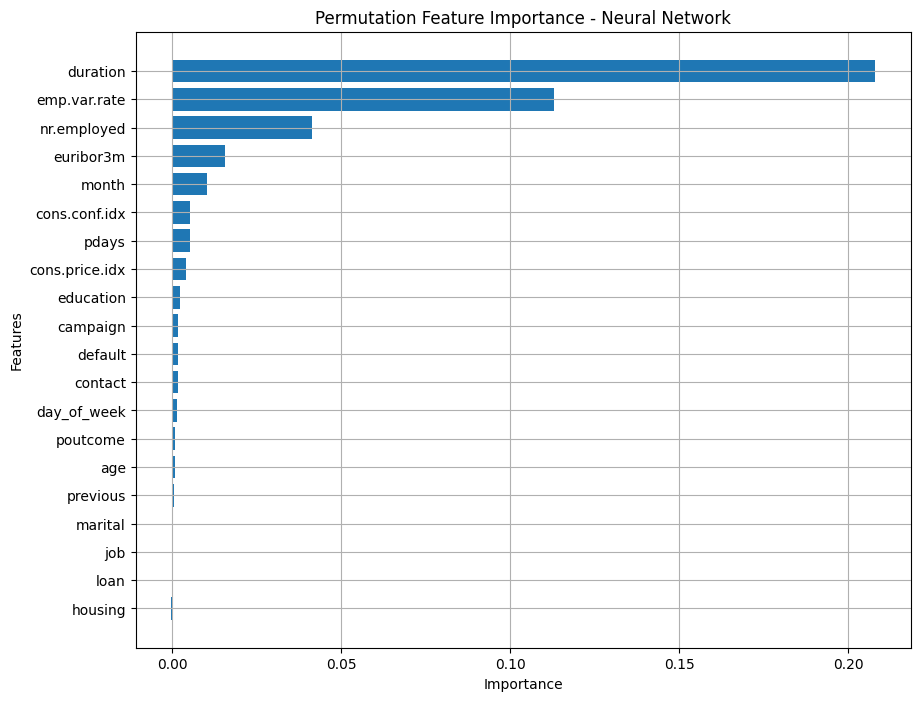

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Subset Features: Index(['housing', 'loan', 'job', 'marital', 'previous'], dtype='object')
Subset Accuracy: 0.9206117989803351
Subset ROC-AUC: 0.9516949502335016


In [ ]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# Retrain Neural Network with optimized parameters
mlp_optimized = MLPClassifier(
    activation='tanh',
    hidden_layer_sizes=(128, 64, 32),
    learning_rate_init=0.001,
    solver='sgd',
    max_iter=400,
    random_state=42
)
mlp_optimized.fit(X_train, y_train)

# Calculate Permutation Importance
perm_importance = permutation_importance(mlp_optimized, X_test, y_test, scoring='roc_auc', n_repeats=5, random_state=42)

# Sort and plot feature importance
sorted_indices_nn = perm_importance.importances_mean.argsort()
plt.figure(figsize=(10, 8))
plt.barh(X_test.columns[sorted_indices_nn], perm_importance.importances_mean[sorted_indices_nn])
plt.title("Permutation Feature Importance - Neural Network")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.grid()
plt.show()

# Identify least important features
least_important_nn = X_test.columns[sorted_indices_nn][:5]

# Subset Experiment: Drop least important features
X_train_subset_nn = X_train.drop(columns=least_important_nn)
X_test_subset_nn = X_test.drop(columns=least_important_nn)

# Retrain Neural Network with subset features
mlp_subset = MLPClassifier(
    activation='tanh',
    hidden_layer_sizes=(128, 64, 32),
    learning_rate_init=0.001,
    solver='sgd',
    max_iter=400,
    random_state=42
)
mlp_subset.fit(X_train_subset_nn, y_train)

# Evaluate performance
y_pred_subset_nn = mlp_subset.predict(X_test_subset_nn)
y_pred_subset_nn_proba = mlp_subset.predict_proba(X_test_subset_nn)[:, 1]

accuracy_nn_subset = accuracy_score(y_test, y_pred_subset_nn)
roc_auc_nn_subset = roc_auc_score(y_test, y_pred_subset_nn_proba)

print("Subset Features:", least_important_nn)
print("Subset Accuracy:", accuracy_nn_subset)
print("Subset ROC-AUC:", roc_auc_nn_subset)


3. Class Imbalance Handling Experiments

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Original class distribution:\n", y_train.value_counts())
print("Balanced class distribution (SMOTE):\n", pd.Series(y_train_smote).value_counts())

# 1. Random Forest with SMOTE-balanced data
rf_smote = RandomForestClassifier(
    n_estimators=150,
    max_depth=20,
    min_samples_split=10,
    random_state=42
)
rf_smote.fit(X_train_smote, y_train_smote)
y_pred_rf_smote = rf_smote.predict(X_test)
y_pred_rf_smote_proba = rf_smote.predict_proba(X_test)[:, 1]

accuracy_rf_smote = accuracy_score(y_test, y_pred_rf_smote)
roc_auc_rf_smote = roc_auc_score(y_test, y_pred_rf_smote_proba)
cm_rf_smote = confusion_matrix(y_test, y_pred_rf_smote)

# 2. Neural Network with SMOTE-balanced data
mlp_smote = MLPClassifier(
    activation='tanh',
    hidden_layer_sizes=(128, 64, 32),
    learning_rate_init=0.001,
    solver='sgd',
    max_iter=400,
    random_state=42
)
mlp_smote.fit(X_train_smote, y_train_smote)
y_pred_nn_smote = mlp_smote.predict(X_test)
y_pred_nn_smote_proba = mlp_smote.predict_proba(X_test)[:, 1]

accuracy_nn_smote = accuracy_score(y_test, y_pred_nn_smote)
roc_auc_nn_smote = roc_auc_score(y_test, y_pred_nn_smote_proba)
cm_nn_smote = confusion_matrix(y_test, y_pred_nn_smote)

# Results
print("Random Forest with SMOTE:")
print("Accuracy:", accuracy_rf_smote)
print("ROC-AUC:", roc_auc_rf_smote)
print("Confusion Matrix:\n", cm_rf_smote)

print("\nNeural Network with SMOTE:")
print("Accuracy:", accuracy_nn_smote)
print("ROC-AUC:", roc_auc_nn_smote)
print("Confusion Matrix:\n", cm_nn_smote)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Original class distribution:
 y
0    29238
1     3712
Name: count, dtype: int64
Balanced class distribution (SMOTE):
 y
0    29238
1    29238
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


Random Forest with SMOTE:
Accuracy: 0.9061665452779801
ROC-AUC: 0.9494963648049436
Confusion Matrix:
 [[6743  567]
 [ 206  722]]

Neural Network with SMOTE:
Accuracy: 0.8858946346200534
ROC-AUC: 0.9290979232510967
Confusion Matrix:
 [[6608  702]
 [ 238  690]]


4. Performance Consistency Experiments

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# Function to perform experiments for a given train-test split
def train_test_experiment(test_size, model_name):
    print(f"\n--- {model_name}: Train-Test Split ({int((1 - test_size) * 100)}% Train / {int(test_size * 100)}% Test) ---")

    # Split the data with stratification
    X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )

    # Random Forest
    if model_name == 'Random Forest':
        rf_exp = RandomForestClassifier(
            n_estimators=150, max_depth=20, min_samples_split=10, random_state=42
        )
        rf_exp.fit(X_train_exp, y_train_exp)
        y_pred_exp = rf_exp.predict(X_test_exp)
        y_pred_exp_proba = rf_exp.predict_proba(X_test_exp)[:, 1]

    # Neural Network
    elif model_name == 'Neural Network':
        mlp_exp = MLPClassifier(
            activation='tanh',
            hidden_layer_sizes=(128, 64, 32),
            learning_rate_init=0.001,
            solver='sgd',
            max_iter=400,
            random_state=42
        )
        mlp_exp.fit(X_train_exp, y_train_exp)
        y_pred_exp = mlp_exp.predict(X_test_exp)
        y_pred_exp_proba = mlp_exp.predict_proba(X_test_exp)[:, 1]

    # Evaluation
    accuracy_exp = accuracy_score(y_test_exp, y_pred_exp)
    roc_auc_exp = roc_auc_score(y_test_exp, y_pred_exp_proba)
    cm_exp = confusion_matrix(y_test_exp, y_pred_exp)

    print("Accuracy:", accuracy_exp)
    print("ROC-AUC:", roc_auc_exp)
    print("Confusion Matrix:\n", cm_exp)
    return accuracy_exp, roc_auc_exp

# Run Experiments for Different Splits
splits = [0.3, 0.1]  # 70/30 and 90/10 splits
results_rf = {}
results_nn = {}

for split in splits:
    # Random Forest Experiment
    acc_rf, roc_rf = train_test_experiment(split, 'Random Forest')
    results_rf[f"{int((1-split)*100)}/{int(split*100)}"] = (acc_rf, roc_rf)

    # Neural Network Experiment
    acc_nn, roc_nn = train_test_experiment(split, 'Neural Network')
    results_nn[f"{int((1-split)*100)}/{int(split*100)}"] = (acc_nn, roc_nn)

# Results Summary
print("\n--- Performance Summary ---")
print("Random Forest Results:", results_rf)
print("Neural Network Results:", results_nn)



--- Random Forest: Train-Test Split (70% Train / 30% Test) ---
Accuracy: 0.9167273610099539
ROC-AUC: 0.9478854479508992
Confusion Matrix:
 [[10627   338]
 [  691   701]]

--- Neural Network: Train-Test Split (70% Train / 30% Test) ---


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.9121145909201263
ROC-AUC: 0.9421652488849055
Confusion Matrix:
 [[10597   368]
 [  718   674]]

--- Random Forest: Train-Test Split (90% Train / 10% Test) ---
Accuracy: 0.9244962369507161
ROC-AUC: 0.9506530378791452
Confusion Matrix:
 [[3554  101]
 [ 210  254]]

--- Neural Network: Train-Test Split (90% Train / 10% Test) ---
Accuracy: 0.9142995872784656
ROC-AUC: 0.9453223029388179
Confusion Matrix:
 [[3562   93]
 [ 260  204]]

--- Performance Summary ---
Random Forest Results: {'70/30': (0.9167273610099539, 0.9478854479508992), '90/10': (0.9244962369507161, 0.9506530378791452)}
Neural Network Results: {'70/30': (0.9121145909201263, 0.9421652488849055), '90/10': (0.9142995872784656, 0.9453223029388179)}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


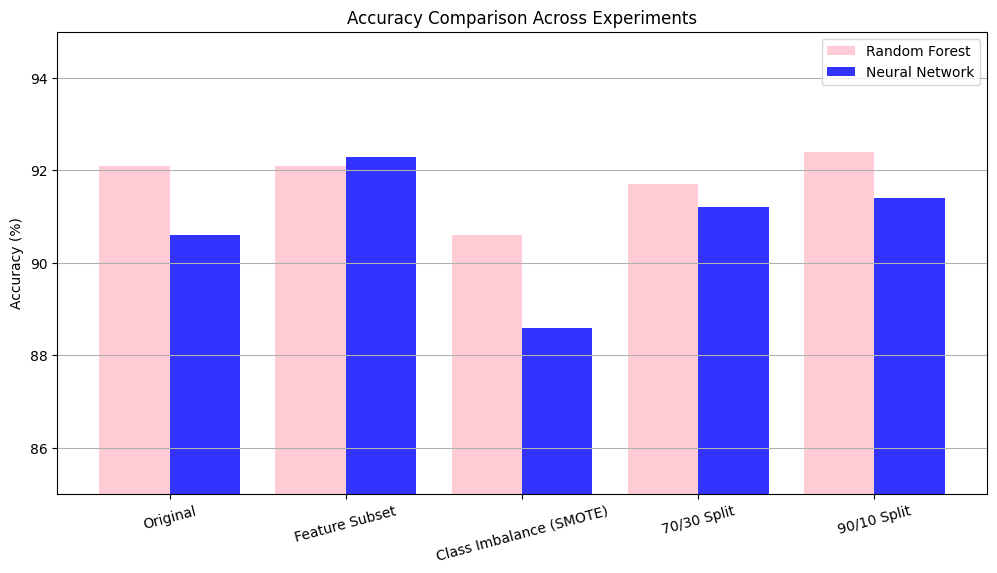

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for visualization
categories = ["Original", "Feature Subset", "Class Imbalance (SMOTE)", "70/30 Split", "90/10 Split"]

# Random Forest results
rf_accuracy = [92.1, 92.1, 90.6, 91.7, 92.4]


# Neural Network results
nn_accuracy = [90.6, 92.3, 88.6, 91.2, 91.4]

# X-axis positions
x = np.arange(len(categories))


# Visualization for Accuracy
plt.figure(figsize=(12, 6))
plt.bar(x - 0.2, rf_accuracy, width=0.4, label='Random Forest', color='pink', alpha=0.8)
plt.bar(x + 0.2, nn_accuracy, width=0.4, label='Neural Network', color='blue', alpha=0.8)
plt.xticks(x, categories, rotation=15)
plt.ylim(85, 95)
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Comparison Across Experiments")
plt.legend()
plt.grid(axis='y')
plt.show()



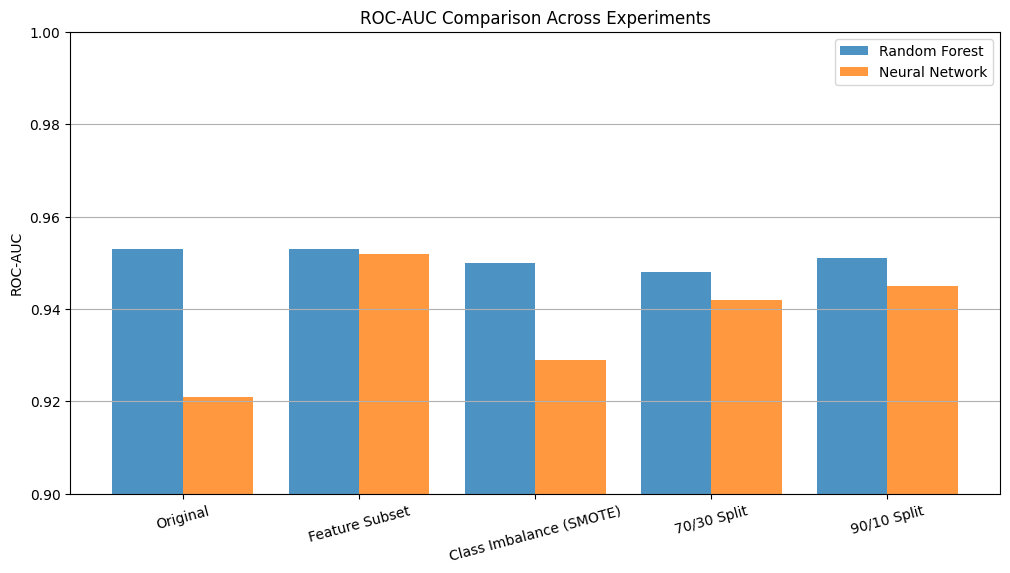

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for visualization
categories = ["Original", "Feature Subset", "Class Imbalance (SMOTE)", "70/30 Split", "90/10 Split"]

# Random Forest results
rf_roc_auc = [0.953, 0.953, 0.950, 0.948, 0.951]

# Neural Network results
nn_roc_auc = [0.921, 0.952, 0.929, 0.942, 0.945]

x = np.arange(len(categories))  # X-axis positions

# Visualization for ROC-AUC
plt.figure(figsize=(12, 6))
plt.bar(x - 0.2, rf_roc_auc, width=0.4, label='Random Forest', alpha=0.8)
plt.bar(x + 0.2, nn_roc_auc, width=0.4, label='Neural Network', alpha=0.8)
plt.xticks(x, categories, rotation=15)
plt.ylim(0.9, 1.0)
plt.ylabel("ROC-AUC")
plt.title("ROC-AUC Comparison Across Experiments")
plt.legend()
plt.grid(axis='y')
plt.show()


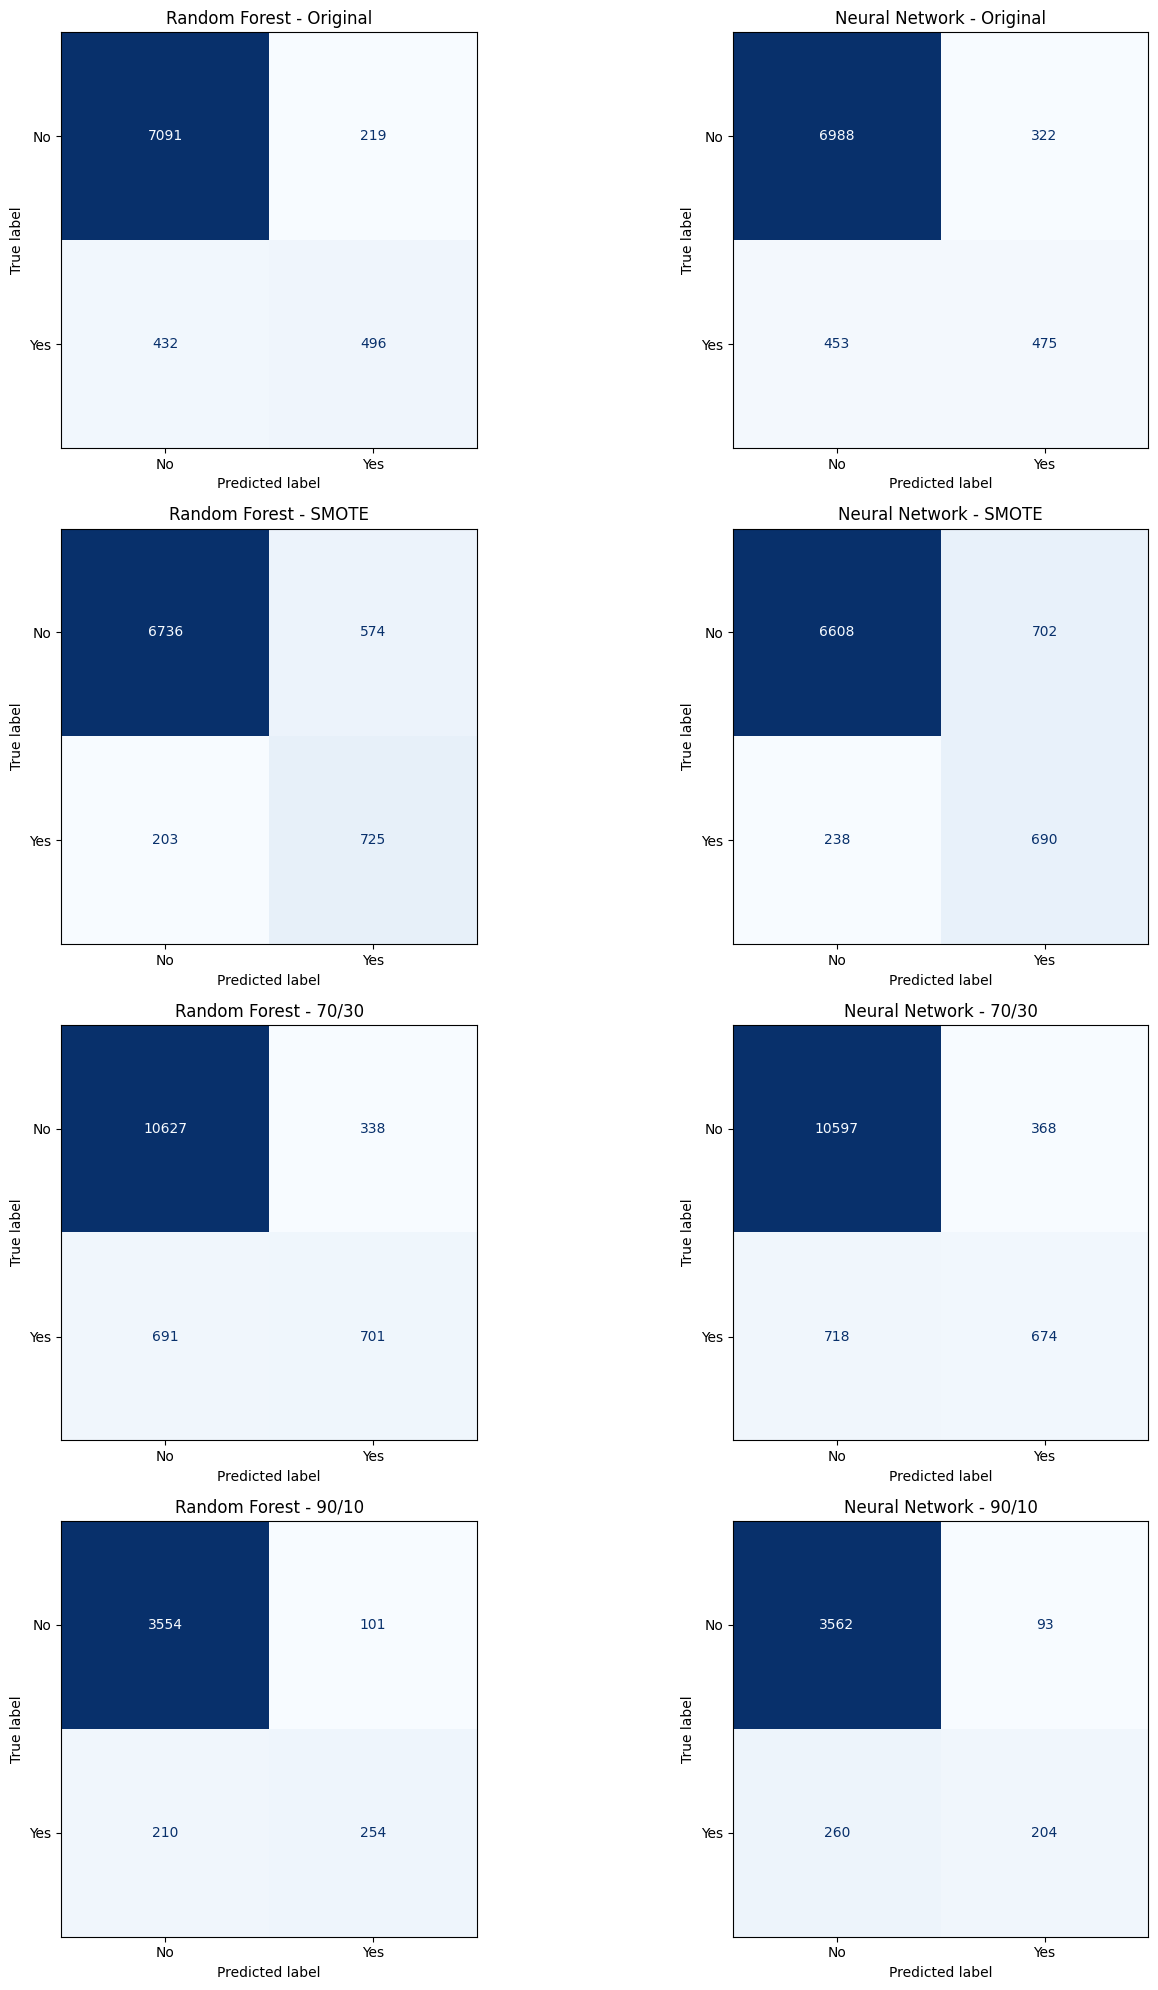

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

# Confusion Matrices
confusion_matrices = {
    "Random Forest - Original": [[7091, 219], [432, 496]],
    "Neural Network - Original": [[6988, 322], [453, 475]],
    "Random Forest - SMOTE": [[6736, 574], [203, 725]],
    "Neural Network - SMOTE": [[6608, 702], [238, 690]],
    "Random Forest - 70/30": [[10627, 338], [691, 701]],
    "Neural Network - 70/30": [[10597, 368], [718, 674]],
    "Random Forest - 90/10": [[3554, 101], [210, 254]],
    "Neural Network - 90/10": [[3562, 93], [260, 204]],
}

# Visualization of Confusion Matrices
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.flatten()

for i, (title, cm) in enumerate(confusion_matrices.items()):
    disp = ConfusionMatrixDisplay(confusion_matrix=np.array(cm), display_labels=["No", "Yes"])
    disp.plot(cmap="Blues", ax=axes[i], colorbar=False)
    axes[i].set_title(title)

plt.tight_layout()
plt.show()
